C:\Users\migue\AppData\Local\Temp\ipykernel_9092\3844794250.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])
C:\Users\migue\AppData\Local\Temp\ipykernel_9092\3844794250.py:132: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ry_gate = RY(i, point[i])


The initial calssification is 40.54054054054054 % accurate


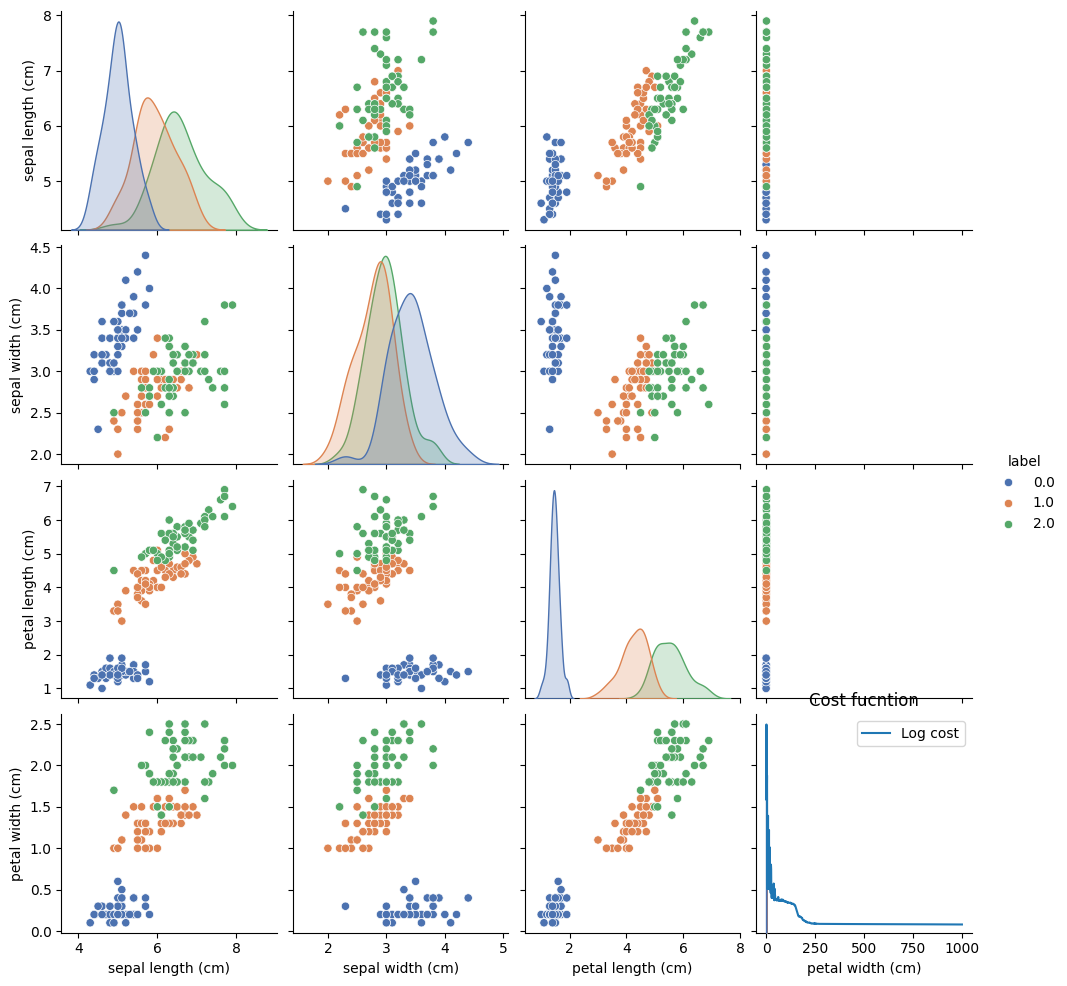

C:\Users\migue\AppData\Local\Temp\ipykernel_9092\3844794250.py:398: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if test_df.iloc[i][5] == test_df.iloc[i][6]:


The final calssification is 94.69026548672566 % accurate.


ImportError: Numba needs NumPy 2.1 or less. Got NumPy 2.2.

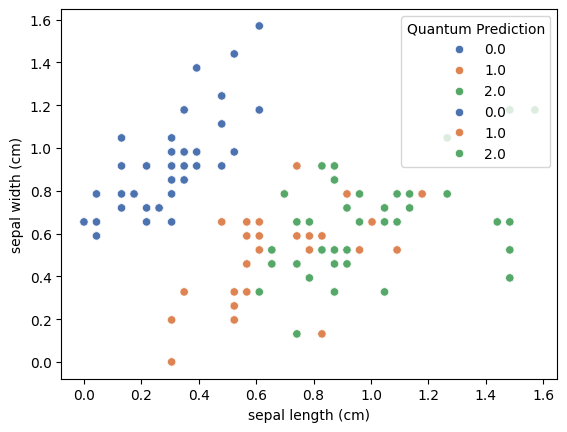

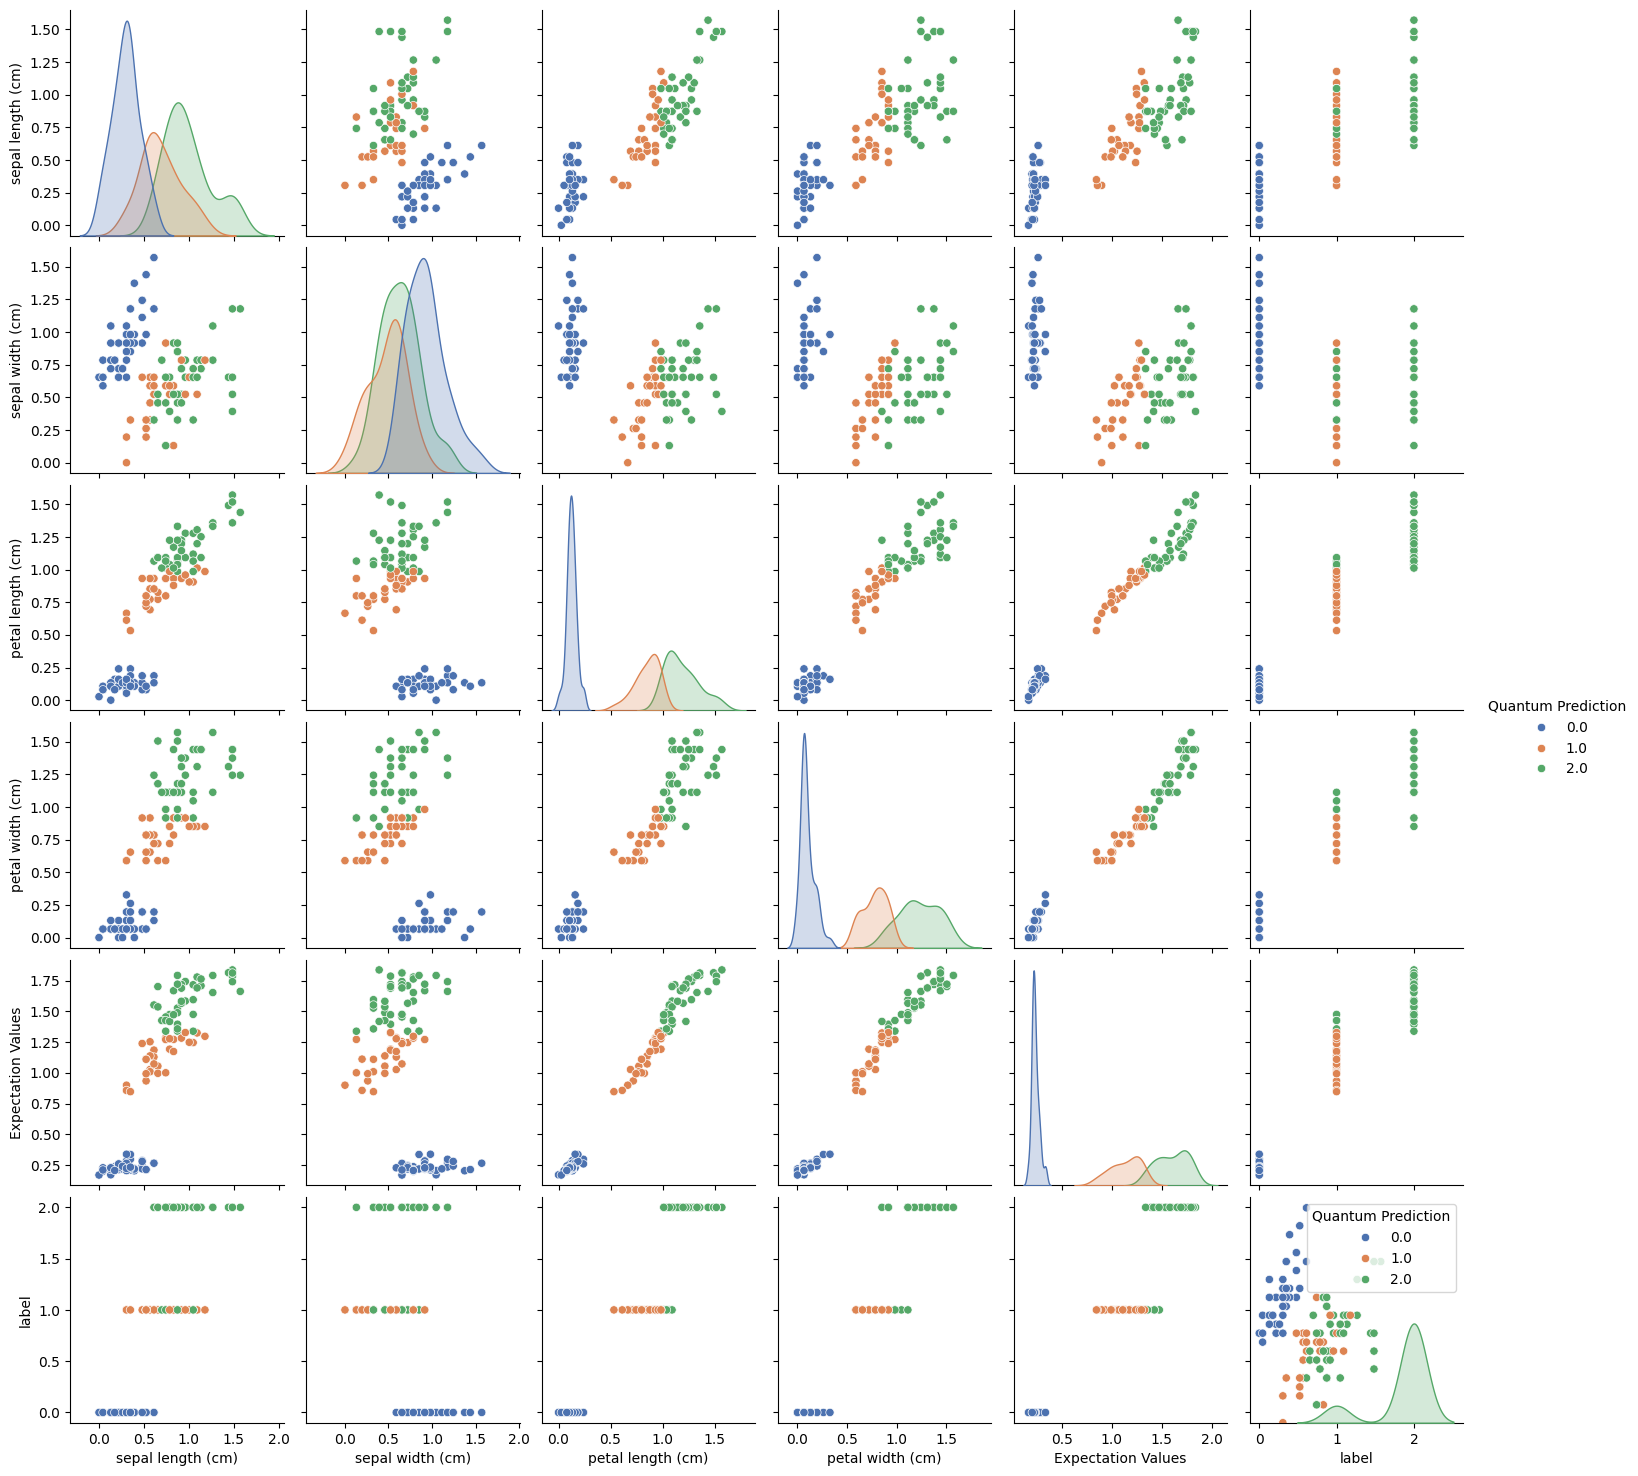

In [5]:

import qulacs
import numpy as np
from qulacs import QuantumState
from qulacs.gate import X, RY, RZ, DenseMatrix
from sklearn.datasets import load_iris
import seaborn as sns
import pandas as pd 
from matplotlib import pyplot as plt


iris = load_iris()
iris.DESCR

# %%
iris.data.shape,iris.target.shape

# %%
#Load iris data and classification to the same array.
features = iris.feature_names
features.append('label')
data = np.zeros((150,5))
data[:,0:4] = iris.data
data[:,4] = iris.target

# %%
iris_df = pd.DataFrame(data = data, columns = features)

# %%
iris_df.head(100)

# %%
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.75, random_state=42)

train_data = np.zeros((X_train.shape[0], X_train.shape[1] + 1))
train_data[:,0:4] = X_train
train_data[:,4] = y_train
train_df = pd.DataFrame(data = train_data, columns = features)

test_data = np.zeros((X_test.shape[0], X_test.shape[1] + 1))
test_data[:,0:4] = X_test
test_data[:,4] = y_test
test_df = pd.DataFrame(data = test_data, columns = features)

# %% [markdown]
# Featurewise pair plots:

# %%
sns.pairplot(iris_df, hue="label", palette = 'deep')

# %% [markdown]
# ## Data preprocessing, embedding and computational circuit

# %% [markdown]
# The data array has the form (x,y), where x is the feature vector and y is tge label. The feature vector has 4 element and the labels are 0,1,2 respectivly. To use a parameterised quantum circuit each data vector x must be transformed to a tensor product of qubits.
# 
# Encoding this data into qubits can be done in a number of ways. To begin with I will repeat the work done by Dominic, and use the qubit embedding $x_n^d \mapsto \bigotimes_{n=1}^4 cos(x_n^d) |0> + sin(x_n^d) |1>$ where $x_n^d$ is the nth feature of the dth sample. Note that this embedded state is the tensor product of 4 qubits, which gives a state vector of size $2^4 = 16$. Note also that for the qubit embedding we require all the x values be in the range $[0,\frac{\pi}{2})$.
# 
# To encode the data I will initialise 4 cubits in the $|0>$ computational basis state and operate on each them with the gate $U(X_n^d) := e^{-ix_n^d\sigma_y}$. This process will encode a single data points.
# 
# But first, the data will need normalising as described above.

# %% [markdown]
# ### Preprocessing

# %% [markdown]
# Test train split:

# %%
#This function takes a data set and returns a qubit embedding of the data.
#Normalise from the bottom
def half_pi_norm(data):
  #Normalise data
  dim = data.shape[1]
  min_values = np.zeros(dim)

  for i in range(dim):
    min_values[i] = np.amin(data[:,i])
    data[:,i] = data[:,i] - min_values[i]

  largest_values = np.zeros(dim)
  
  for i in range(dim):
    largest_values[i] = np.amax(data[:,i])


  #Normalise classical data
  normalised_data = np.zeros((data.shape[0],dim))

  for i in range(dim):

    normalised_data[:,i] = data[:,i]*(np.pi/(2*largest_values[i]))

  return normalised_data

# %% [markdown]
# Rescaled to be between 0 and pi/2 using pandas dataframe functions

# %%
train_df[train_df.columns[:4]] -= train_df[train_df.columns[:4]].min()
train_df[train_df.columns[:4]] /= train_df[train_df.columns[:4]].max()
train_df[train_df.columns[:4]] *= np.pi/2

# %%
train_df.head()

# %%
test_df[test_df.columns[:4]] -= test_df[test_df.columns[:4]].min()
test_df[test_df.columns[:4]] /= test_df[test_df.columns[:4]].max()
test_df[test_df.columns[:4]] *= np.pi/2

# %%
test_df.head()

# %%
#normed_train_data = half_pi_norm(X_train)
#normed_test_data = half_pi_norm(X_test)

# %% [markdown]
# ### Embedding circuit (Qubit Embedding)

# %% [markdown]
# Now I create the embedding circuit as a function that acts on a point and returns a quantum state.

# %%
#Function to perform pointwise qubit embedding.
def pointwise_qubit_embedding(point):
  n = len(point)
  state = QuantumState(n)
  state.set_zero_state()
  for i in range(n):
    ry_gate = RY(i, point[i])
    ry_gate.update_quantum_state(state)

  return state

# %% [markdown]
# ### Computational Circuit 

# %% [markdown]
# To build two qubit gates one needs to use combinations of single qubit gates and control operations.
# 
# I am copy the state after each operation for comparison.

# %% [markdown]
# Now its time for a parameterised quantum circuit.
# 
# Each two qubit unitary will be specified by two angles

# %%
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
#Circuit 6 Hur et al
def U_conv_6():
  #Metadata
  n = 4
  depth = 3
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(2,3)
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)  
  circuit.add_CNOT_gate(1,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RY_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

# %%
circuit = U_conv_6()
circuit.get_parameter_count

# %%
from qulacs import ParametricQuantumCircuit
from qulacs import QuantumState
import numpy as np
def U_dom():
  #Metadata
  n = 4
  depth = 3
  
  angle = 0
  # construct parametric quantum circuit with random rotation
  circuit = ParametricQuantumCircuit(n)

  target_layer_1 = np.array([0,1,2,3], dtype = 'int')
  for i in target_layer_1:
    circuit.add_parametric_RY_gate(target_layer_1[i],angle)
  circuit.add_CNOT_gate(0,1)
  circuit.add_CNOT_gate(3,2)

  target_layer_2 = [1,2]
  for i in range(len(target_layer_2)):
    circuit.add_parametric_RZ_gate(target_layer_2[i],angle)
  circuit.add_CNOT_gate(1,2)

  circuit.add_parametric_RY_gate(2,angle)

  return circuit

# %% [markdown]
# ## Get expectation
# 
# The below function will return the expectation scaled between 2 and 0.

# %%
def get_expectation(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)

  return exp + 1

# %% [markdown]
# 

# %% [markdown]
# # Trinary Clasification

# %%
from qulacs import Observable

# %% [markdown]
# ## prepare circuit data

# %%
circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(circuit.get_parameter_count()):
  circuit.set_parameter(i,theta_0[i])

# %%
circuit.get_parameter

# %%
parameter_count = circuit.get_parameter_count()
param = [circuit.get_parameter(ind) for ind in range(parameter_count)]

# %%
param

# %% [markdown]
# NOTE TO SELF
# 
# use pca on the components to see what the most important eigen vlaues/vectors are doing.

# %%
train_df.head()

# %% [markdown]
# ## Define operators and make initial predictions
# Initatial expectation and classification is prior to training.
# 
# I will use the Pauli Z operator to take the expectation of the unitary evolution of embedded data points.

# %%
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

# %%
#Classify and expectation value that is reshaped to be between 0 and 2.
def classify_tri(exp):
  if exp >= 1.33:
    pred = 2
  elif exp < 1.33 and exp > 0.66:
    pred = 1
  else:
    pred = 0
  return pred

# %% [markdown]
# Below I visualise the naive predictions on the training data. Clearly the predictions are sub optimal.

# %%
expectation = []
for i in range(len(train_df)):
  expectation.append(get_expectation(train_df.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df.insert(4,'Expectation', expectation)


# %% [markdown]
# Naive expectation values with random angle, very poor but thats expected.

# %%
def cost_train(theta):
  #get predictions
  expect = np.zeros(len(train_df))
  for i in range(len(train_df)):
    expect[i] = get_expectation(train_df.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #Sxpectation values
  L = ((expect - y_train)**2).mean()
  cost_values.append(L)
  return L

# %%
theta = np.random.rand(17)

# %%
train_df.head()

# %%
#find number of correct predictions
correct = 0
for i in range(len(y_train)):
  if y_train[i] == classify_tri(train_df['Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')


# %% [markdown]
# ## Optimise
# The updated parameters are generated and tested below:

# %%
from scipy.optimize import minimize #BFGS works well/cobyla

# %%
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
cost_values = []
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')

theta = result.x


# %%
plt.plot(np.linspace(0,len(cost_values)-1,len(cost_values)-1).round(),(cost_values[:-1]),label = 'Log cost')
#Plot the difference between the exact and trial function
plt.ylabel('L')
plt.xlabel('Iteration')
plt.title('Cost fucntion')
plt.legend(loc="best")
plt.show()

# %% [markdown]
# ## Reclasify

# %%
def cost_test(theta):
  #get predictions
  expect = np.zeros(len(test_df))
  for i in range(len(test_df)):
    expect[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((expect - y_test)**2).mean()

  return L

# %%
cost_test(theta),cost_test(theta_0)

# %%
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

test_df.insert(4,'Expectation Values', expectations)
test_df.insert(5,'Quantum Prediction', better_predictions)

# %%
correct = 0
for i in range(len(test_df)):
  if test_df.iloc[i][5] == test_df.iloc[i][6]:
    correct += 1 

print('The final calssification is',(correct/len(test_df)) * 100, '% accurate.')

# %% [markdown]
# ## Prediction graphs

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='label', palette="deep")

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Quantum Prediction', palette="deep")

# %%
sns.pairplot(test_df, hue="Quantum Prediction", palette = 'deep')

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Quantum Prediction', palette="deep")

# %% [markdown]
# Generate shadded boundary values by generating and fitting a model

# %% [markdown]
# ## Feature space landscape and local Interpretability of solution
# 
# Stop using pandas, its shit.
# 
# CPU/GPU kernel for classification

# %%
import numba
from numba import jit, njit

# %%
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
feature_space.columns = features[0:4]

# %%
feature_space

# %% [markdown]
# Make predictions on the feature space mesh grid

# %%
"""fs_pred = np.zeros(len(feature_space))

"""
def get_fs_pred():
  fs_exp = np.zeros(len(feature_space))
  fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
    fs_exp[i] = get_expectation(feature_space.iloc[i][0:4],U_conv_6, theta)
    fs_pred[i] = classify_tri(fs_exp[i])

  return fs_pred, fs_exp

  
pred, exp = get_fs_pred()
feature_space.insert(4,'Expectation Values', exp)
feature_space.insert(5,'Quantum Prediction', pred)

# %%
feature_space.reindex(np.random.permutation(feature_space.index)).head(40300)

# %%
feature_space['Expectation Values']

# %%
#feature_space = feature_space[feature_space['Quantum Prediction'] != 2]

# %%
#Plotting erros against dimension
plt.scatter(np.array(feature_space.iloc[:,0]),np.array(feature_space.iloc[:,1]),label = 'Error against dimension')

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Error compared to sample functions')
plt.legend(loc="best")
plt.show()

# %%
sns.pairplot(feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# %% [markdown]
# # Binary Classification 

# %%
sns.scatterplot(data=data, x=data[:,0], y=data[:,1], hue=data[:,4], palette="deep")

# %% [markdown]
# 

# %%
sns.scatterplot(data=data, x=data[:,2], y=data[:,3], hue=data[:,4], palette="deep")

# %% [markdown]
# ## Convert and visualise data
# 
# The embedding and computational circuits will be unchanged.

# %%
#Copy data and alter labels for binar classification.
y_test_bi = y_test
y_train_bi = y_train

X_test_bi = X_test
X_train_bi = X_train

for i in range(len(X_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1


# %%
X_test_bi[1]

# %%
normed_train_data_bi = half_pi_norm(X_train_bi)
normed_test_data_bi = half_pi_norm(X_test_bi)

# %%
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(iris.data, iris.target, test_size=0.33, random_state=42)

for i in range(len(y_test_bi)):
  if y_test_bi[i] == 2:
    y_test_bi[i] = 1

for i in range(len(y_train_bi)):
  if y_train_bi[i] == 2:
    y_train_bi[i] = 1

train_data_bi = np.zeros((X_train_bi.shape[0], X_train_bi.shape[1] + 1))
train_data_bi[:,0:4] = X_train_bi
train_data_bi[:,4] = y_train_bi
train_df_bi = pd.DataFrame(data = train_data_bi, columns = features)

test_data_bi = np.zeros((X_test_bi.shape[0], X_test_bi.shape[1] + 1))
test_data_bi[:,0:4] = X_test_bi
test_data_bi[:,4] = y_test_bi
test_df_bi = pd.DataFrame(data = test_data_bi, columns = features)

# %%
train_df_bi[train_df_bi.columns[:4]] -= train_df_bi[train_df_bi.columns[:4]].min()
train_df_bi[train_df_bi.columns[:4]] /= train_df_bi[train_df_bi.columns[:4]].max()
train_df_bi[train_df_bi.columns[:4]] *= np.pi/2

# %%
test_df_bi[test_df_bi.columns[:4]] -= test_df_bi[test_df_bi.columns[:4]].min()
test_df_bi[test_df_bi.columns[:4]] /= test_df_bi[test_df_bi.columns[:4]].max()
test_df_bi[test_df_bi.columns[:4]] *= np.pi/2

# %%
a = np.random.rand(5)

a[[1,4,2]]

# %%
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

# %%
features

# %%
#sns.pairplot(train_df_bi, hue="label", palette = 'deep')

# %%
y_train, expectations

# %%
def get_expectation_bi(x, U, theta):
  #define PQC
  circuit =  U()
  for i in range(circuit.get_parameter_count()):
    circuit.set_parameter(i,theta[i])

  #Define and embed data point, x is an element of the normalised data set
  point = x
  state = pointwise_qubit_embedding(point)
  circuit.update_quantum_state(state)
  obs = Observable(4)
  obs.add_operator(1.,'Z 1')
  exp = obs.get_expectation_value(state)
  #print(exp)
  exp = (exp + 1)/2
  

  return exp

# %%
#Binary cost function:
def bi_cost_train(theta):
  #get expectations
  expectations = np.zeros(len(train_df_bi))
  for i in range(len(train_df_bi)):
    expectations[i] = get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6, theta)
  #Simple MSE example
  
  #predictions are currently expectation values
  L = ((expectations - y_train)**2).mean()
  #print(L)
  #print(expectations)
  return L

# %%
#Define the binary VQC and set initial values of theta
bi_circuit = U_conv_6()
theta_0 = np.random.rand(17)
for i in range(bi_circuit.get_parameter_count()):
  bi_circuit.set_parameter(i,theta_0[i])

parameter_count = bi_circuit.get_parameter_count()
param = [bi_circuit.get_parameter(ind) for ind in range(parameter_count)]
param

# %%
#Define the pauli matrix for which the expectation will be taken.
from qulacs import PauliOperator
p_s = 'Z 1'
z = PauliOperator(p_s,1)

# %%
x = train_df_bi.iloc[0][0:4]
xp = get_expectation_bi(x,U_dom,theta)

# %%
#Classify and expectation value that is reshaped to be between 0 and 1.
def classify_bi(exp):
  if exp >= 0.5:
    pred = 1
  else:
    pred = 0
  return pred

# %%
bi_expectation = []
for i in range(len(train_df_bi)):
  bi_expectation.append(get_expectation_bi(train_df_bi.iloc[i][0:4],U_conv_6,np.random.rand(17)))
train_df_bi.insert(4,'Test Binary Expectation', bi_expectation)

# %%
#find number of correct predictions
correct = 0
for i in range(len(train_df_bi)):
  if train_df_bi['label'][i] == classify_bi(train_df_bi['Test Binary Expectation'][i]):
    correct += 1

print('The initial calssification is',(correct/len(y_train)) * 100, '% accurate')

# %%
train_df_bi['Binary Expectation'] = bi_expectation

# %%
train_df_bi

# %% [markdown]
# ## Optimise

# %%
#%%time
#Use scipy minimised to find the vector theta that minimised the cost function.
theta_0 = np.random.rand(17)
result = minimize(cost_train, theta_0, method='cobyla')
theta = result.x

# %%
def bi_cost_test(theta):
  #get predictions
  predictions_bi = np.zeros(len(test_df_bi))
  for i in range(len(test_df_bi)):
    predictions_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6,theta)
  #Simple MSE example
  L = ((predictions_bi - y_test)**2).mean()
  return L

# %%
theta, theta_0

# %%
bi_cost_test(theta),bi_cost_test(theta_0)

# %%
bi_better_predictions = np.zeros(len(test_df_bi))
expectation_bi = np.zeros(len(test_df_bi))
for i in range(len(test_df_bi)):
  bi_better_predictions[i] = classify_bi(get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta))
  expectation_bi[i] = get_expectation_bi(test_df_bi.iloc[i][0:4],U_conv_6, theta)

test_df_bi.insert(4,'Expectation Values', expectation_bi)
test_df_bi.insert(5,'Quantum Prediction', bi_better_predictions)

# %%
test_df_bi.head()

# %%
correct = 0
for i in range(len(test_df_bi)):
  if test_df_bi.iloc[i][5] == test_df_bi.iloc[i][6]:
    correct += 1 

print('The final classification is',(correct/len(test_df_bi)) * 100, '% accurate on the test data')

# %%
sns.scatterplot(data=test_df_bi, x=test_df_bi.iloc[:,0], y=test_df_bi.iloc[:,1], hue="Quantum Prediction", palette="deep")

# %%
sns.pairplot(test_df_bi, hue="Quantum Prediction", palette = 'deep')

# %%
sns.scatterplot(data=normed_test_data_bi, x=normed_test_data_bi[:,0], y=normed_test_data_bi[:,1], hue=y_test_bi, palette="deep")

# %% [markdown]
# ## Feature space landscape and local interpretability of solution

# %%
N = 30
w = np.linspace(0,np.pi/2,N, endpoint = True)
x = np.linspace(0,np.pi/2,N, endpoint = True)
y = np.linspace(0,np.pi/2,N, endpoint = True)
z = np.linspace(0,np.pi/2,N, endpoint = True)

ww, xx, yy, zz = np.meshgrid(w,x,y,z)

w_flat = ww.reshape(N**4)
x_flat = xx.reshape(N**4)
y_flat = yy.reshape(N**4)
z_flat = zz.reshape(N**4)
fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

bi_feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
bi_feature_space.columns = features[0:4]

# %%
def get_bi_fs_pred():
  bi_fs_exp = np.zeros(len(feature_space))
  bi_fs_pred = np.zeros(len(feature_space))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(bi_feature_space.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
bi_pred, bi_exp = get_bi_fs_pred()
bi_feature_space.insert(4,'Expectation Values', bi_exp)
bi_feature_space.insert(5,'Quantum Prediction', bi_pred)

# %%
sns.pairplot(bi_feature_space.sample(500), hue = 'Quantum Prediction', palette = 'deep')

# %% [markdown]
# # Classical model + LIME

# %% [markdown]
# 

# %%
import sklearn
import sklearn.datasets
import sklearn.ensemble
import numpy as np
import lime
import lime.lime_tabular
#from __future__ import print_function
np.random.seed(1)

# %% [markdown]
# ## Train random forest classifier

# %%
train_df.head(), test_df.head()

# %%
#training data features
train_df[train_df.columns[:6]]

# %%
#Call model from sklearn
rf = sklearn.ensemble.RandomForestClassifier(n_estimators=500)
rf.fit(train_df[train_df.columns[:4]], train_df[train_df.columns[5]])

# %%
classical_predictions = rf.predict(test_df[test_df.columns[:4]])

# %%
test_df.insert(6,'Classical Prediction', classical_predictions)

# %%
correct = 0
for i in range(len(test_df['label'])): 
  if test_df['label'][i] == test_df['Classical Prediction'][i]:
    correct += 1
percent_correct = correct*100/len(test_df)
print('The percentage of correct assignments for the classical random forest is ', percent_correct, '%')

# %%
test_df.head()

# %%
sns.scatterplot(data=test_df, x=test_df.iloc[:,0], y=test_df.iloc[:,1], hue='Classical Prediction', palette="deep")

# %%
fig, ax = plt.subplots(2, figsize=(10, 6))

colours = {0 : 'green', 1 : 'red', 2 : 'blue'}

ax[0].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,6].map(colours))
ax[0].set_title("Predictions")
#ax[0].set_xlabel("Sepal Length")
ax[0].set_ylabel("Sepal Width")

ax[1].scatter(test_df.iloc[:,0],test_df.iloc[:,1], c = test_df.iloc[:,7].map(colours))
ax[1].set_title("True Labels")
ax[1].set_xlabel("Sepal Length")
ax[1].set_ylabel("Sepal Width")

colours = {'0' : 'green', '1' : 'red', '2' : 'blue'}

plt.show()

# %%
train_df.head()

# %% [markdown]
# ## Quantum classifier

# %%
classes = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  classes[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)

# %%
classes[:10], expectations[:10], test_df.iloc[:10]['label']

# %%
data = np.array(train_df.iloc[:,:4].values)

# %%
better_predictions = np.zeros(len(test_df))
expectations = np.zeros(len(test_df))
for i in range(len(test_df)):
  better_predictions[i] = classify_tri(get_expectation(test_df.iloc[i][0:4],U_conv_6, theta))
  expectations[i] = get_expectation(test_df.iloc[i][0:4],U_conv_6, theta)


# %% [markdown]
# ## Classical Explainer

# %%
origional_explainer = lime.lime_tabular.LimeTabularExplainer(test_df.iloc[:,:4].values, feature_names=test_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)

# %%
i = np.random.randint(0, test_df.shape[0])
origional_exp = origional_explainer.explain_instance(test_df.iloc[:,:4].values[49], rf.predict_proba, num_features=2, top_labels=3)

# %%
origional_exp.show_in_notebook(show_table=True, show_all=True)

# %% [markdown]
# ## Q explainer

# %%
###Assign probabilities
def create_probabilities(input_X):

  if input_X.ndim == 1:
    input_X = np.reshape(input_X,(1,input_X.shape[0]))
  expectation_values = np.zeros(input_X.shape[0])
  for i in range(input_X.shape[0]):
    expectation_values[i] = get_expectation(input_X[i],U_conv_6, theta)
    probabilities = np.zeros((input_X.shape[0],3))
  for i in range(input_X.shape[0]):
    e = expectation_values[i]
    magnitude = 2*(np.abs(e-1)+np.abs(e-2)+np.abs(e-0))
    p_0 = (np.abs(e-1)+np.abs(e-2))/magnitude
    p_1 = (np.abs(e-0)+np.abs(e-2))/magnitude
    p_2 = (np.abs(e-1)+np.abs(e-0))/magnitude

    if (p_0 < p_1) & (p_0 < p_2):
      p_0 = 0
    if (p_1 < p_0) &( p_1 < p_2):
      p_1 = 0
    if (p_2 < p_0) & (p_2 < p_1):
      p_2 = 0

    probabilities[i,:] = np.array([p_0, p_1, p_2])
    probabilities[i,:] = probabilities[i,:]/(probabilities[i,:].sum())
    
  return probabilities

# %%
from lime.lime_tabular import LimeTabularExplainer

q_explainer = lime.lime_tabular.LimeTabularExplainer(train_df.iloc[:,:4].values, feature_names=train_df.columns[:4], class_names=iris.target_names, discretize_continuous=True)
q_exp = q_explainer.explain_instance(test_df.iloc[:,:4].values[49], create_probabilities, num_features=2, top_labels=3)

# %%
q_exp.show_in_notebook(show_table=True, show_all=True)

# %% [markdown]
# # LIME using a VQC as the explained classifier.

# %%
#Takes a 4d vector and returns a series of points in the local area.
#I assume the point x is in the domain [0,pi/2]
def sample_about_point(x,R,N):
  #N is the number of points over the axis that is considered

  #Consider a hypersquare with the point at the center of side length R
  start_w = max(0,x[0] - R)
  end_w = min(x[0] + R, np.pi/2)
  start_x = max(0,x[1] - R)
  end_x = min(x[1] + R, np.pi/2)
  start_y = max(0,x[2] - R)
  end_y = min(x[2] + R, np.pi/2)
  start_z = max(0,x[3] - R)
  end_z = min(x[3] + R, np.pi/2)

  w = np.linspace(start_w,end_w,N, endpoint = True)
  x = np.linspace(start_x,end_x,N, endpoint = True)
  y = np.linspace(start_y,end_y,N, endpoint = True)
  z = np.linspace(start_z,end_z,N, endpoint = True)

  ww, xx, yy, zz = np.meshgrid(w,x,y,z)

  w_flat = ww.reshape(N**4)
  x_flat = xx.reshape(N**4)
  y_flat = yy.reshape(N**4)
  z_flat = zz.reshape(N**4)
  fs = np.array([w_flat,x_flat, y_flat, z_flat]).reshape(N**4,4)

  feature_space = pd.DataFrame([w_flat,x_flat, y_flat, z_flat]).T
  feature_space.columns = features[0:4]
  return feature_space


# %%
x = np.array([1,1,0.5,1]) 
R = 0.1
N = 20
sample_data = sample_about_point(x,R,N)

# %%
def lime_get_bi_fs_pred(sample_data):
  bi_fs_exp = np.zeros(len(sample_data))
  bi_fs_pred = np.zeros(len(sample_data))

  for i in range(N**4):
     bi_fs_exp[i] = get_expectation_bi(sample_data.iloc[i][0:4],U_conv_6, theta)
     bi_fs_pred[i] = classify_bi(bi_fs_exp[i])
     

  return  bi_fs_pred,  bi_fs_exp  

  
lime_bi_pred, lime_bi_exp = lime_get_bi_fs_pred(sample_data)

sample_data.insert(4,'Expectation Values', lime_bi_exp)
sample_data.insert(5,'Quantum Prediction', lime_bi_pred)

# %%
sample_data = sample_data.sample(100)

# %%
sample_df = pd.DataFrame(sample_data)
sns.pairplot(sample_data, palette = 'magma', hue = 'Expectation Values')

# %%
#find the value of the projector pi_x(z)
def pi_x(x,z):
  #x is the point of interest
  #z is an array of local sample points, not that dataframes must be converted 
  #to numpy arrays.
  #returns projective weights
  projected_weights = np.zeros(z.shape[0])
  for i in range(z.shape[0]):
    projected_weights[i] = np.exp(-(np.linalg.norm(x-z[i])))

  #Using exponential decay kernel
  return projected_weights

# %% [markdown]
# To choose the best model I will create a family of models of differeent types with varying parameter numbers. I will use LASSO regression with K features, where K varies between 1 and 4.

# %%
sample_df.iloc[:,0:4]

# 

In [8]:

# Path to your CSV file
file_path = r"C:\Users\migue\Downloads\9e7fdfb8189f0cdf5d73a494e4a6392a-aaecbd14aeaa468cd749528f291aa8a30c2ea09e\9e7fdfb8189f0cdf5d73a494e4a6392a-aaecbd14aeaa468cd749528f291aa8a30c2ea09e\iris_dataset.csv"

# Read the CSV file into a Pandas DataFrame
irisdf = pd.read_csv(file_path)

#Example preprocessing; different from kaggle! Check and compare for the best preprocesing; No need to scale y since its a categorical value and not a continious one aparently

X = irisdf.drop(columns='target')  # Features
y = irisdf['target']              # Target

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y) #This 2 steps make the non-numerical values of y numerical

# Ensure there are no missing values


# Preprocessing pipeline
features_num = X.columns  # All features are numerical

preprocessor = make_column_transformer(
    (StandardScaler(), features_num),  # StandarScaler makes the data have mean 0 and variance 1 
    )

#X_to_split = X.preprocessor() 
# Split the dataset into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y_encoded, test_size=0.75, random_state=42, stratify=y_encoded
)


# Apply preprocessing to the training and validation sets
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

# One-hot encode the target variables
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)


input_shape = [X_train.shape[1]]

print("Missing values in dataset:\n", irisdf.isnull().sum())
print("Input shape: {}".format(input_shape))

# Print the transformed data shapes and normalized feature example
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("First row of X_train after preprocessing:", X_train[0])

# Display the first few rows of the DataFrame
print("Head of the DataFrame:")
print(irisdf.head())

# Display basic statistics of the DataFrame
print("\nBasic statistics:")
print(irisdf.describe())

# Check for missing values
print("\nMissing values in each column:")
print(irisdf.isnull().sum())

# Display DataFrame info to ensure it is ML-ready
print("\nDataFrame info:")
print(irisdf.info())


Head of the DataFrame:
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

        target  
0  Iris-setosa  
1  Iris-setosa  
2  Iris-setosa  
3  Iris-setosa  
4  Iris-setosa  

Basic statistics:
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.054000           3.758667   
std             0.828066          0.433594           1.764420   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.6

## Back to normal code

In [44]:
def main():
    # Load the Iris dataset
    file_path = r"C:\Users\migue\Downloads\9e7fdfb8189f0cdf5d73a494e4a6392a-aaecbd14aeaa468cd749528f291aa8a30c2ea09e\9e7fdfb8189f0cdf5d73a494e4a6392a-aaecbd14aeaa468cd749528f291aa8a30c2ea09e\iris_dataset.csv"

# Read the CSV file into a Pandas DataFrame
    irisdf = pd.read_csv(file_path)

#Example preprocessing; different from kaggle! Check and compare for the best preprocesing; No need to scale y since its a categorical value and not a continious one aparently

    X = irisdf.drop(columns='target')  # Features
    y = irisdf['target']              # Target

    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y) #This 2 steps make the non-numerical values of y numerical

# Ensure there are no missing values


# Preprocessing pipeline
    features_num = X.columns  # All features are numerical

    preprocessor = make_column_transformer(
        (StandardScaler(), features_num),  # StandarScaler makes the data have mean 0 and variance 1 
        )

#X_to_split = X.preprocessor() 
# Split the dataset into train and validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y_encoded, test_size=0.75, random_state=42, stratify=y_encoded)


# Apply preprocessing to the training and validation sets
    X_train = preprocessor.fit_transform(X_train)
    X_valid = preprocessor.transform(X_valid)

# One-hot encode the target variables
    y_train = to_categorical(y_train)
    y_valid = to_categorical(y_valid)

    # Normalize features to the range [0, π]
    X_train = (X_train - np.min(X_train, axis=0)) / (np.max(X_train, axis=0) - np.min(X_train, axis=0)) * np.pi
    X_valid = (X_valid - np.min(X_valid, axis=0)) / (np.max(X_valid, axis=0) - np.min(X_valid, axis=0)) * np.pi

    # Initialize and train the quantum classifier
    model = QuantumClassifier(n_qubits=4, layers=2, stepsize=0.2, epochs=50)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_valid)

    # Evaluate accuracy
    # Evaluate accuracy
    y_valid_labels = np.argmax(y_valid, axis=1)  # Convert one-hot encoded y_valid back to class labels
    accuracy = accuracy_score(y_valid_labels, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")


if __name__ == "__main__":
    main()

c:\Users\migue\miniconda\Lib\site-packages\pennylane\_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


ValueError: operands could not be broadcast together with shapes (37,) (37,3) 

In [ ]:
# Wrap the QuantumClassifier with One-vs-Rest for multiclass classification
ovr_classifier = OneVsRestClassifier(QuantumClassifier(n_qubits=4, layers=2, stepsize=0.1, epochs=50))

# Fit the model
ovr_classifier.fit(X_train, y_train)

# Make predictions
y_pred = ovr_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


## Just nice snippet of the VC Im using

Expectation Values (Qubit 2): -0.17595405376150475


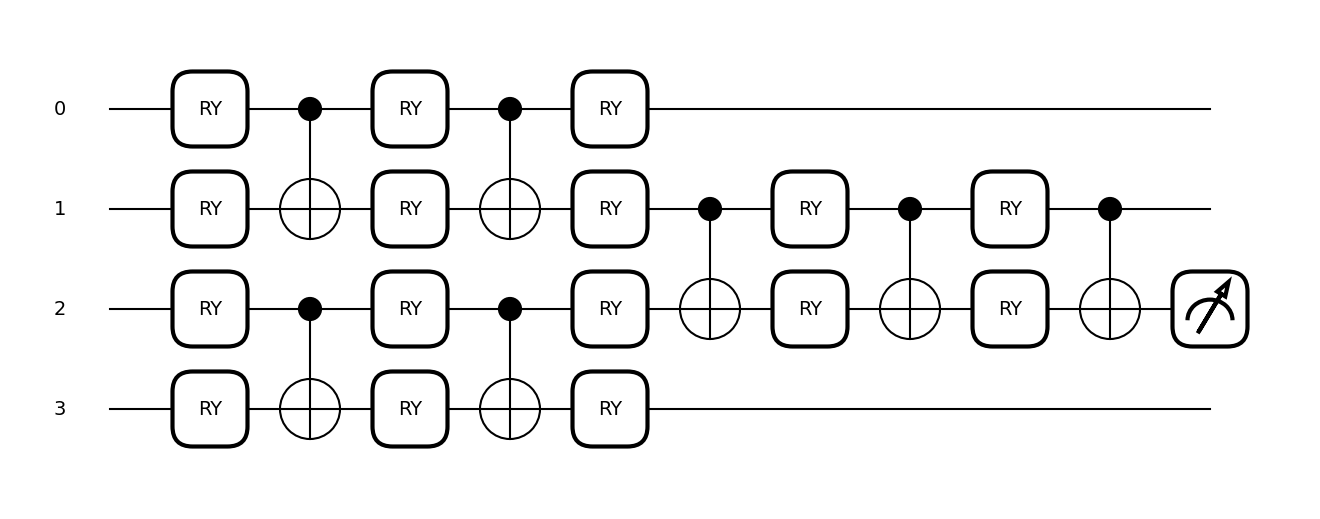

In [ ]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Number of qubits
n_qubits = 4

# Define the quantum device
dev = qml.device('default.qubit', wires=n_qubits)

# Define the variational circuit
@qml.qnode(dev)
def variational_circuit(params):
    # Unpack parameters
    params_ry1, params_ry2, params_ry3, params_ry4, params_ry5 = params

    # Step 1: RY gates on all 4 qubits
    for i in range(n_qubits):
        qml.RY(params_ry1[i], wires=i)

    # Step 2: CNOT gates between qubits 0-1 and 2-3
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])

    # Step 3: RY gates on all 4 qubits
    for i in range(n_qubits):
        qml.RY(params_ry2[i], wires=i)

    # Step 4: CNOT gates between qubits 0-1 and 2-3
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[2, 3])

    # Step 5: RY gates on all 4 qubits
    for i in range(n_qubits):
        qml.RY(params_ry3[i], wires=i)

    # Step 6: CNOT gate between qubits 1-2
    qml.CNOT(wires=[1, 2])

    # Step 7: RY gates on qubits 1 and 2
    qml.RY(params_ry4[0], wires=1)
    qml.RY(params_ry4[1], wires=2)

    # Step 8: CNOT gate between qubits 1-2
    qml.CNOT(wires=[1, 2])

    # Step 9: RY gates on qubits 1 and 2
    qml.RY(params_ry5[0], wires=1)
    qml.RY(params_ry5[1], wires=2)

    # Step 10: CNOT gate between qubits 1-2
    qml.CNOT(wires=[1, 2])

    # Step 11: Measurement on qubit 2.
    return qml.expval(qml.PauliZ(2))

# Initialize parameters
params_ry1 = np.random.rand(n_qubits)  # Parameters for first RY layer
params_ry2 = np.random.rand(n_qubits)  # Parameters for second RY layer
params_ry3 = np.random.rand(n_qubits)  # Parameters for third RY layer
params_ry4 = np.random.rand(2)         # Parameters for RY on qubits 1 and 2
params_ry5 = np.random.rand(2)         # Parameters for final RY on qubits 1 and 2

params = [params_ry1, params_ry2, params_ry3, params_ry4, params_ry5]

# Execute the circuit
output = variational_circuit(params)
print("Expectation Values (Qubit 2):", output)

# Visualize the circuit
fig, ax = qml.draw_mpl(variational_circuit)(params)
plt.show()

In [ ]:
import pennylane as qml
import torch
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

class QuantumClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_qubits=4, layers=2, stepsize=0.05, epochs=100):
        self.n_qubits = n_qubits  # Must be 4 for Iris dataset
        self.layers = layers
        self.stepsize = stepsize
        self.epochs = epochs
        self.params = None
        
        # Quantum setup
        self.dev = qml.device("default.qubit", wires=self.n_qubits)
        
        # Fixed circuit definition with 4 features
        @qml.qnode(self.dev)
        def circuit(params):
            # Feature map using all 4 features
            
            
            # Your original ansatz with 5 parameter groups
            feature_1, params_ry1, params_ry2, params_ry3, params_ry4, params_ry5 = params

            for i in range(self.n_qubits): # Feature map
                qml.RY(feature_1[i], wires=i)


            # [Keep your exact ansatz gates here]
             # Original gate sequence
            for i in range(self.n_qubits):
                qml.RY(params_ry1[i], wires=i)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[2, 3])
            for i in range(self.n_qubits):
                qml.RY(params_ry2[i], wires=i)
            qml.CNOT(wires=[0, 1])
            qml.CNOT(wires=[2, 3])
            for i in range(self.n_qubits):
                qml.RY(params_ry3[i], wires=i)
            qml.CNOT(wires=[1, 2])
            qml.RY(params_ry4[0], wires=1)
            qml.RY(params_ry4[1], wires=2)
            qml.CNOT(wires=[1, 2])
            qml.RY(params_ry5[0], wires=1)
            qml.RY(params_ry5[1], wires=2)
            qml.CNOT(wires=[1, 2])
            return qml.expval(qml.PauliZ(2))
        
        self.circuit = circuit
        self.opt = qml.AdamOptimizer(stepsize=stepsize)     #Why this line

    def fit(self, X, y):
        """Proper parameter initialization for 5 groups"""
        # Initialize all 5 parameter vectors
    

        self.params = [
            torch.tensor(np.random.normal(0, 0.1, 4), requires_grad=True),  # feature_1
            torch.tensor(np.random.normal(0, 0.1, 4), requires_grad=True),  # params_ry1
            torch.tensor(np.random.normal(0, 0.1, 4), requires_grad=True),  # params_ry2
            torch.tensor(np.random.normal(0, 0.1, 4), requires_grad=True),  # params_ry3
            torch.tensor(np.random.normal(0, 0.1, 2), requires_grad=True),  # params_ry4
            torch.tensor(np.random.normal(0, 0.1, 2), requires_grad=True)   # params_ry5
        ]

        
        # Training loop
        for epoch in range(self.epochs):
            self.params = self.opt.step(self._cost, self.params, X, y)
            loss = self._cost(self.params, X, y)
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}: Loss = {loss:.4f}")
        return self

    def _cost(self, params, X, y):
   
        if X.shape[1] != 4:
            raise ValueError(f"Expected 4 features, got {X.shape[1]}")
    
    # Loop over all samples
        expectations = np.array([self.circuit(params)])
        M = 1.5 * (1 + np.clip(expectations, -1, 1))
        return np.mean((M - y) ** 2)

def main():
    # Data loading with explicit 4-feature check
    file_path = r"C:\Users\migue\Downloads\9e7fdfb8189f0cdf5d73a494e4a6392a-aaecbd14aeaa468cd749528f291aa8a30c2ea09e\9e7fdfb8189f0cdf5d73a494e4a6392a-aaecbd14aeaa468cd749528f291aa8a30c2ea09e\iris_dataset.csv"
    irisdf = pd.read_csv(file_path)
    X = irisdf[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']]  # Explicit 4 columns
    y = LabelEncoder().fit_transform(irisdf['target'])
    
    # Split and normalize to [0, π]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = MinMaxScaler(feature_range=(0, np.pi))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Train and test
    model = QuantumClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")



       
if __name__ == "__main__":
    main()
   


NameError: name 'params' is not defined

c:\Users\migue\miniconda\Lib\site-packages\pennylane\_grad.py:216: UserWarning: Attempted to differentiate a function with no trainable parameters. If this is unintended, please add trainable parameters via the 'requires_grad' attribute or 'argnum' keyword.
  warnings.warn(


TypeError: 'int' object is not subscriptable

In [1]:
import torch

print(torch.__file__)

c:\Users\migue\miniconda\Lib\site-packages\torch\__init__.py
